In [1]:
import random
import os
import time
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout

from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model

In [2]:
TRAINING_DIR = '/content/drive/MyDrive/images_compressed'
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
EPOCHS = 14
LEARNING_RATE = .0001

In [3]:
print(f"There are {len(os.listdir(TRAINING_DIR))} images in training set")

There are 5762 images in training set


In [4]:
data = pd.read_csv('/content/images.csv')

In [5]:
data['image'] = data['image']+'.jpg'
data_1 = data[['image', 'label']]

In [6]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(TRAINING_DIR).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

/content/drive/MyDrive/images_compressed/c60e486d-10ed-4f64-abab-5bb698c736dd.jpg
/content/drive/MyDrive/images_compressed/d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg
/content/drive/MyDrive/images_compressed/b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg
/content/drive/MyDrive/images_compressed/784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg
/content/drive/MyDrive/images_compressed/1d0129a1-f29a-4a3f-b103-f651176183eb.jpg
/content/drive/MyDrive/images_compressed/040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg


In [8]:
corrupted = ['b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg', '1d0129a1-f29a-4a3f-b103-f651176183eb.jpg',
             'c60e486d-10ed-4f64-abab-5bb698c736dd.jpg', 'd028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg',
             '040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg', '784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg']

In [9]:
data_1 = data_1.drop(data_1[data_1['image'].isin(corrupted)].index, axis=0)

In [10]:
fig = px.bar(data_1['label'].value_counts())
fig.show()

In [11]:
class_names = list(data_1['label'].unique())
print(len(class_names))
class_names

20


['Not sure',
 'T-Shirt',
 'Shoes',
 'Shorts',
 'Shirt',
 'Pants',
 'Skirt',
 'Other',
 'Top',
 'Outwear',
 'Dress',
 'Body',
 'Longsleeve',
 'Undershirt',
 'Hat',
 'Polo',
 'Blouse',
 'Hoodie',
 'Skip',
 'Blazer']

In [12]:
class_dict = dict(zip(class_names, range(len(class_names))))
class_dict

{'Not sure': 0,
 'T-Shirt': 1,
 'Shoes': 2,
 'Shorts': 3,
 'Shirt': 4,
 'Pants': 5,
 'Skirt': 6,
 'Other': 7,
 'Top': 8,
 'Outwear': 9,
 'Dress': 10,
 'Body': 11,
 'Longsleeve': 12,
 'Undershirt': 13,
 'Hat': 14,
 'Polo': 15,
 'Blouse': 16,
 'Hoodie': 17,
 'Skip': 18,
 'Blazer': 19}

In [13]:
labels_to_remove = ['Skip', 'Not sure', 'Other', 'Blouse']
data_1 = data_1[~data_1['label'].isin(labels_to_remove)]

In [14]:
fig = px.bar(data_1['label'].value_counts())
fig.show()

In [15]:
y_train = data_1['label']

In [16]:
def show_random_training_image():
    random_index = random.choice(data_1.index)
    img_path = data_1['image'][random_index]
    label = data_1['label'][random_index]
    complete_path = TRAINING_DIR + '/' + img_path
    image = mpimg.imread(complete_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)

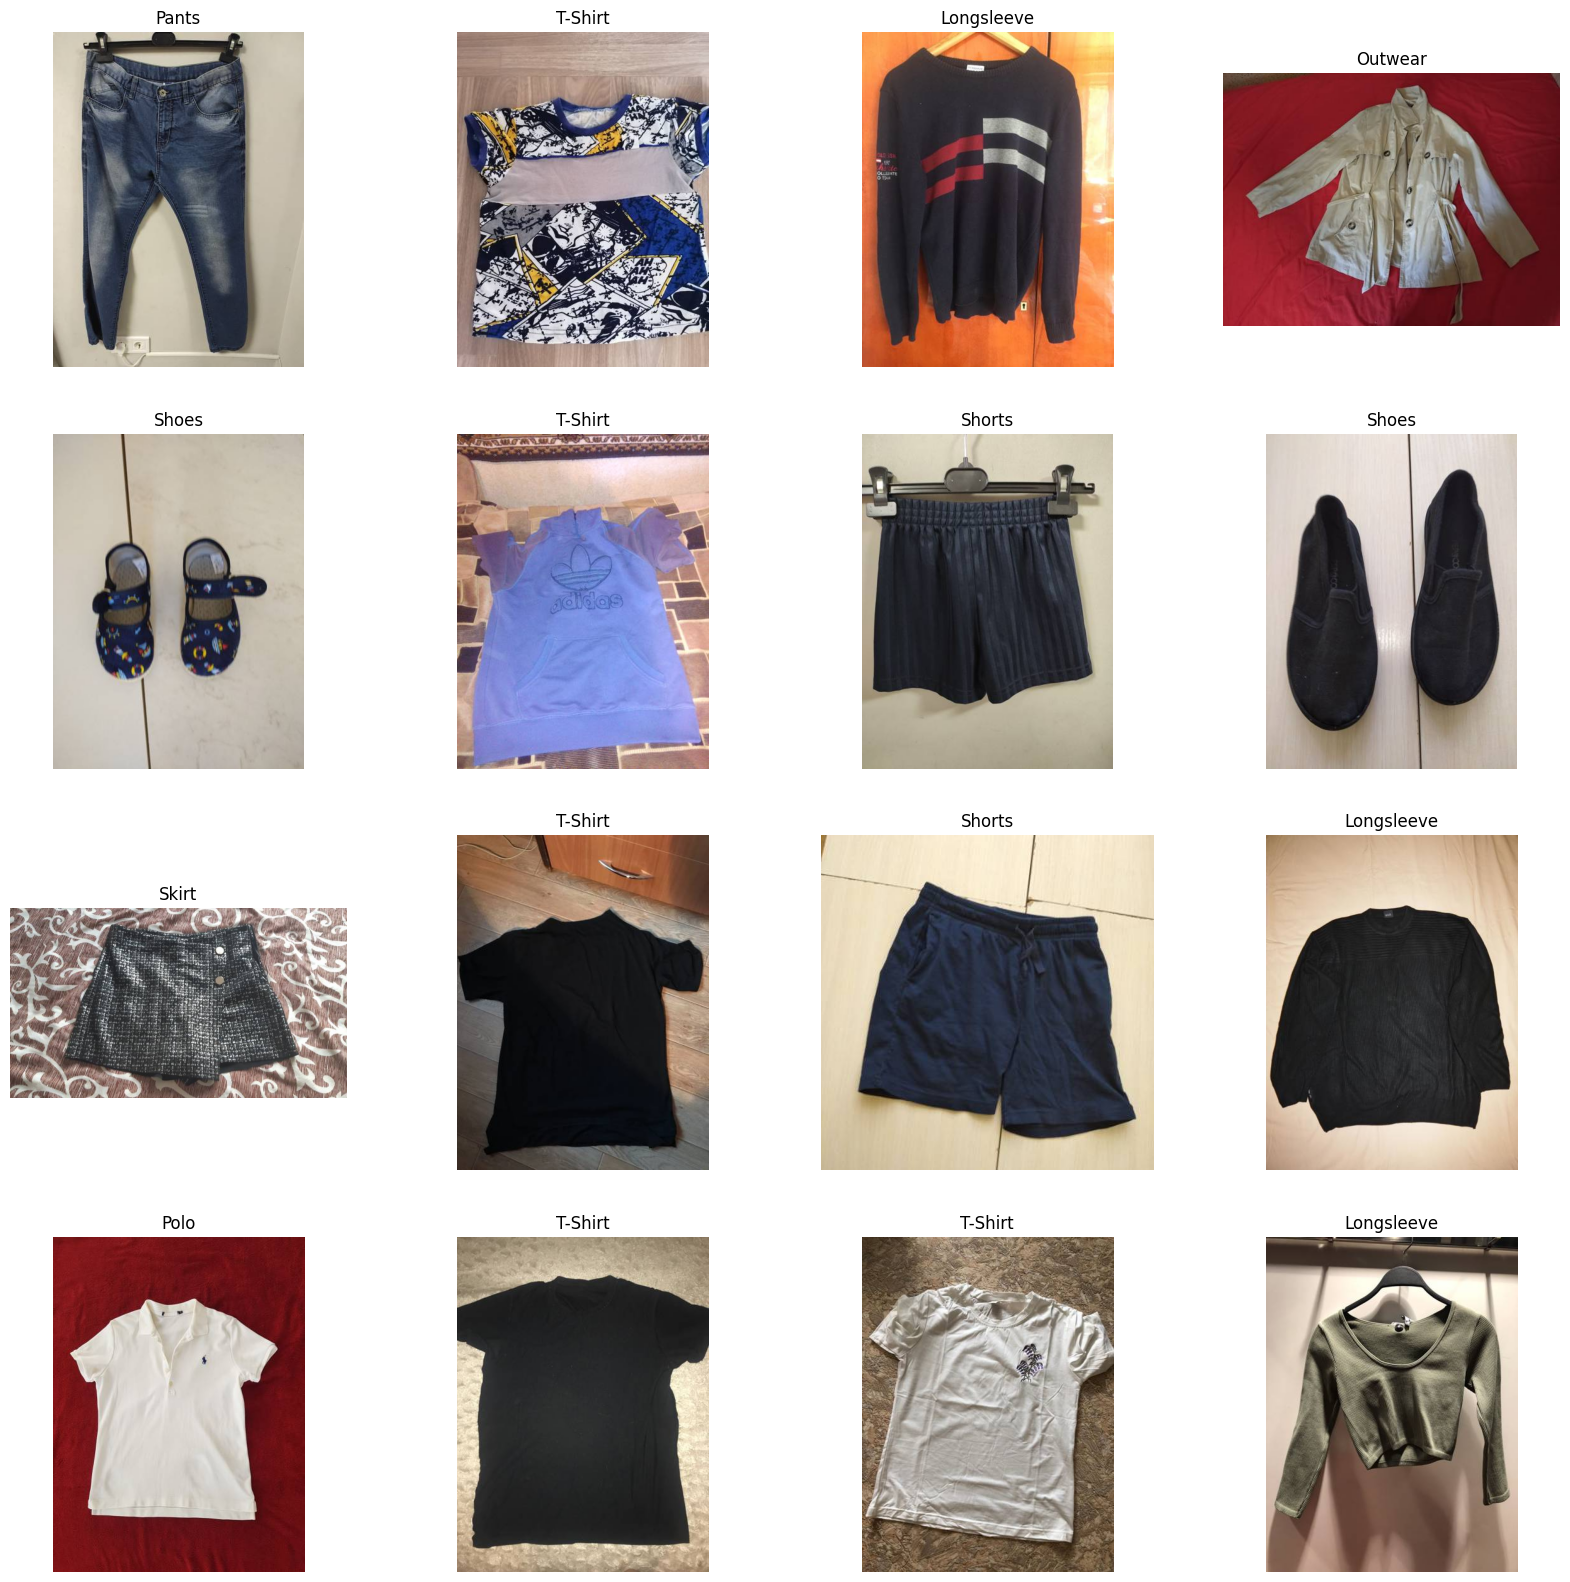

In [17]:
plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    show_random_training_image()

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.3,
                                  height_shift_range=0.3,
                                  zoom_range=0.3,
                                  horizontal_flip=True,
                                  validation_split=0.1)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_1,
    directory=TRAINING_DIR,
    x_col='image',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=data_1,
    directory=TRAINING_DIR,
    x_col='image',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset='validation'
)

Found 4566 validated image filenames belonging to 16 classes.
Found 507 validated image filenames belonging to 16 classes.


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
import numpy as np
import os

In [20]:
TRAINING_DIR = '/content/drive/MyDrive/images_compressed'


In [21]:

def load_images_and_labels(training_dir, image_size=(64, 64)):
    images = []
    labels = []

    for _, row in data_1.iterrows():
        img_path = os.path.join(training_dir, row['image'])
        label = row['label']
        img = Image.open(img_path).resize(image_size)
        img_array = np.array(img).flatten()
        images.append(img_array)
        labels.append(label)

    return np.array(images), np.array(labels)


In [24]:
X, Y = load_images_and_labels(TRAINING_DIR)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


dt_classifier = DecisionTreeClassifier()


In [25]:
# Train the model
dt_classifier.fit(X_train, y_train)

y_pred = dt_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.29458128078817736


In [26]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

pre_trained_model = MobileNetV2(input_shape=(224, 224, 3),
                                include_top=False,
                                weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = True

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('out_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

9406464/9406464 [==============================] - 0s 0us/step
last layer output shape:  (None, 7, 7, 1280)


In [27]:
x = Flatten()(last_output)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.3)(x)
x = Dense(16, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

In [28]:
from tensorflow.keras.optimizers import Adam

learn_rate = LEARNING_RATE

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
cb = ModelCheckpoint('mobilenetv2.h5', save_best_only=True)
lrr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_lr=1e-5)

adam = Adam(learning_rate=learn_rate)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

history = model.fit(train_generator, epochs=EPOCHS,
                    validation_data=validation_generator,
                    callbacks=[es, cb, lrr])

Epoch 1/14
143/143 [==============================] - 1016s 7s/step - loss: 6.7893 - accuracy: 0.3815 - val_loss: 6.7149 - val_accuracy: 0.3886 - lr: 1.0000e-04
Epoch 2/14
143/143 [==============================] - 969s 7s/step - loss: 5.4951 - accuracy: 0.5534 - val_loss: 5.6798 - val_accuracy: 0.5227 - lr: 1.0000e-04
Epoch 3/14
143/143 [==============================] - 932s 7s/step - loss: 4.7552 - accuracy: 0.6202 - val_loss: 4.8573 - val_accuracy: 0.5996 - lr: 1.0000e-04
Epoch 4/14
143/143 [==============================] - 943s 7s/step - loss: 4.1551 - accuracy: 0.6678 - val_loss: 4.4011 - val_accuracy: 0.6272 - lr: 1.0000e-04
Epoch 5/14
143/143 [==============================] - 956s 7s/step - loss: 3.6809 - accuracy: 0.7065 - val_loss: 3.8173 - val_accuracy: 0.6746 - lr: 1.0000e-04
Epoch 6/14
143/143 [==============================] - 928s 6s/step - loss: 3.2658 - accuracy: 0.7339 - val_loss: 3.7407 - val_accuracy: 0.6568 - lr: 1.0000e-04
Epoch 7/14
143/143 [===================

In [29]:

model = tf.keras.models.load_model('mobilenetv2.h5')

In [30]:
loss, accuracy = model.evaluate(validation_generator, verbose=0)

In [31]:
print(f"Model Loss is {loss:.2f} and Accuracy is {100*np.round(accuracy, 4)}%")

Model Loss is 2.00 and Accuracy is 74.16%


In [32]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

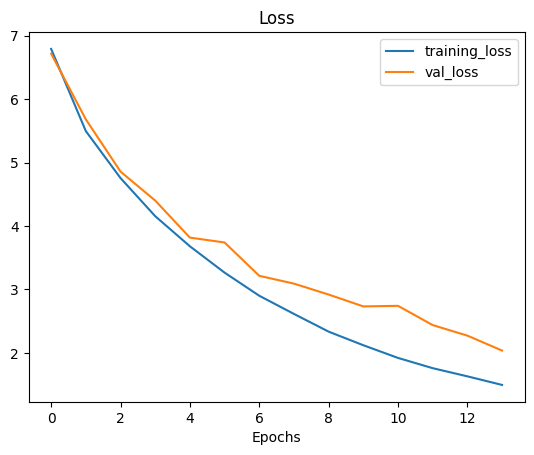

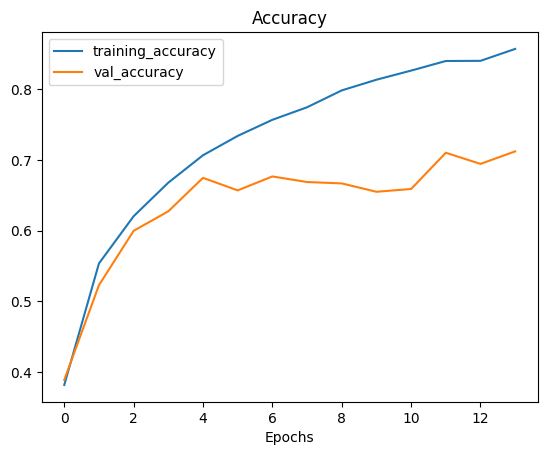

In [33]:
plot_loss_curves(history)

In [34]:
classes = list(train_generator.class_indices.keys())

In [35]:
def predict_val_image(index):
    predictions =  model.predict(val_images, verbose=0)[index]
    true_label = classes[val_labels[index].argmax()]
    predicted_label = classes[predictions.argmax()]

    if(true_label== predicted_label):
        color = 'green'
    else:
        color = 'red'

    plt.title(f"True : {true_label} Predicted: {predicted_label}", color=color)
    plt.imshow(val_images[index])
    plt.axis('off')

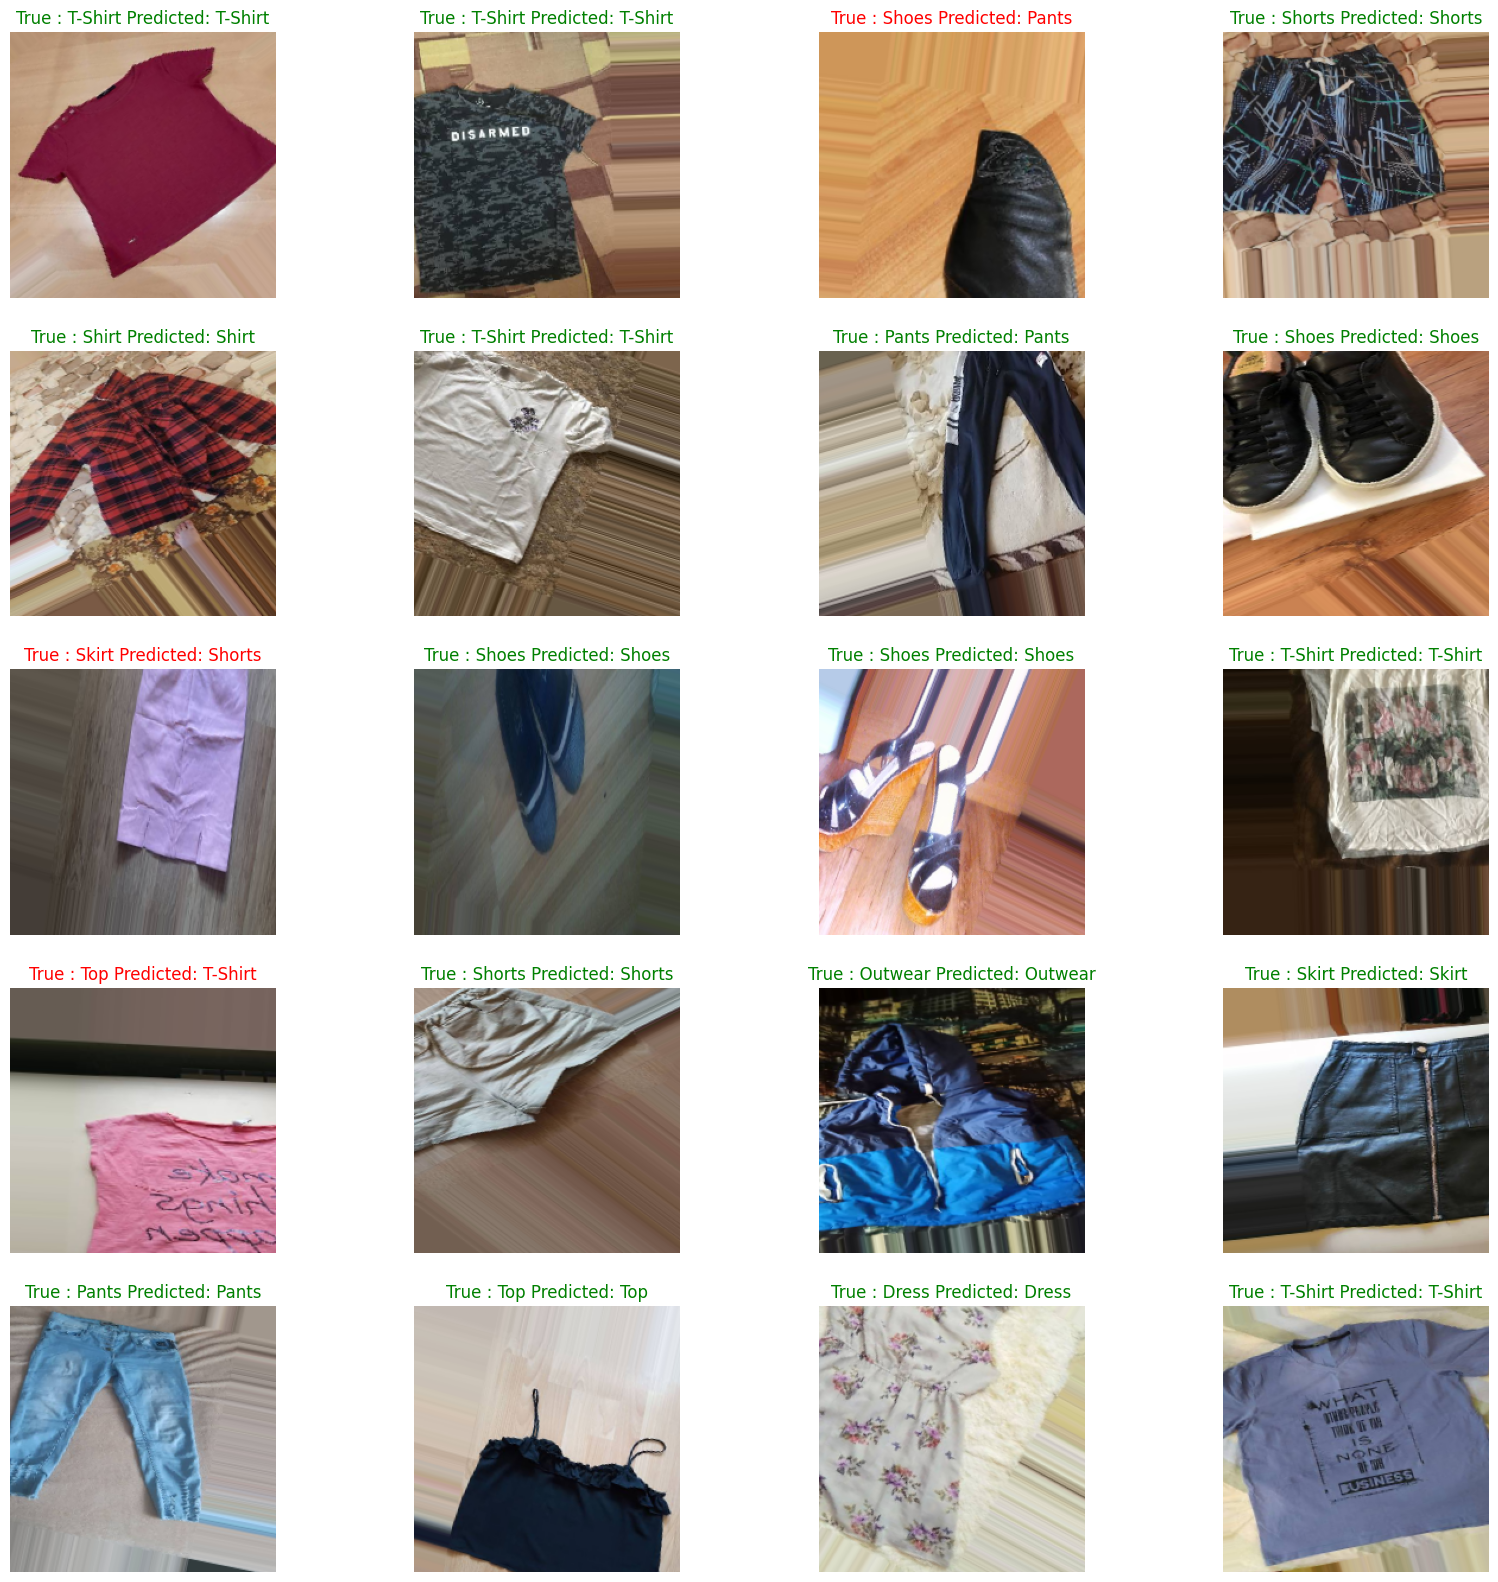

In [36]:
val_images, val_labels = validation_generator.next()
plt.figure(figsize=(20, 20))
for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    predict_val_image(i)

In [37]:
custom_dir = '/content/drive/MyDrive/images_original'

In [38]:
custom_paths = []
for image in os.listdir(custom_dir):
        custom_paths.append(custom_dir+'/'+image)

In [39]:
def predict_random_image():
    path = random.choice(custom_paths)
    image = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    input_arr = input_arr.astype('float32') / 255.
    predictions = model.predict(input_arr, verbose=0)
    series = pd.Series(predictions[0], index=classes)
    predicted_classes = np.argsort(predictions)
    predictions.sort()
    plt.title(f"{classes[predicted_classes[0][-1]]} - {round(predictions[0][-1] * 100,2)}% \n{classes[predicted_classes[0][-2]]} - {round(predictions[0][-2] * 100,2)}% \n{classes[predicted_classes[0][-3]]} - {round(predictions[0][-2] * 100,3)}%")
    plt.imshow(image)
    plt.axis('off')

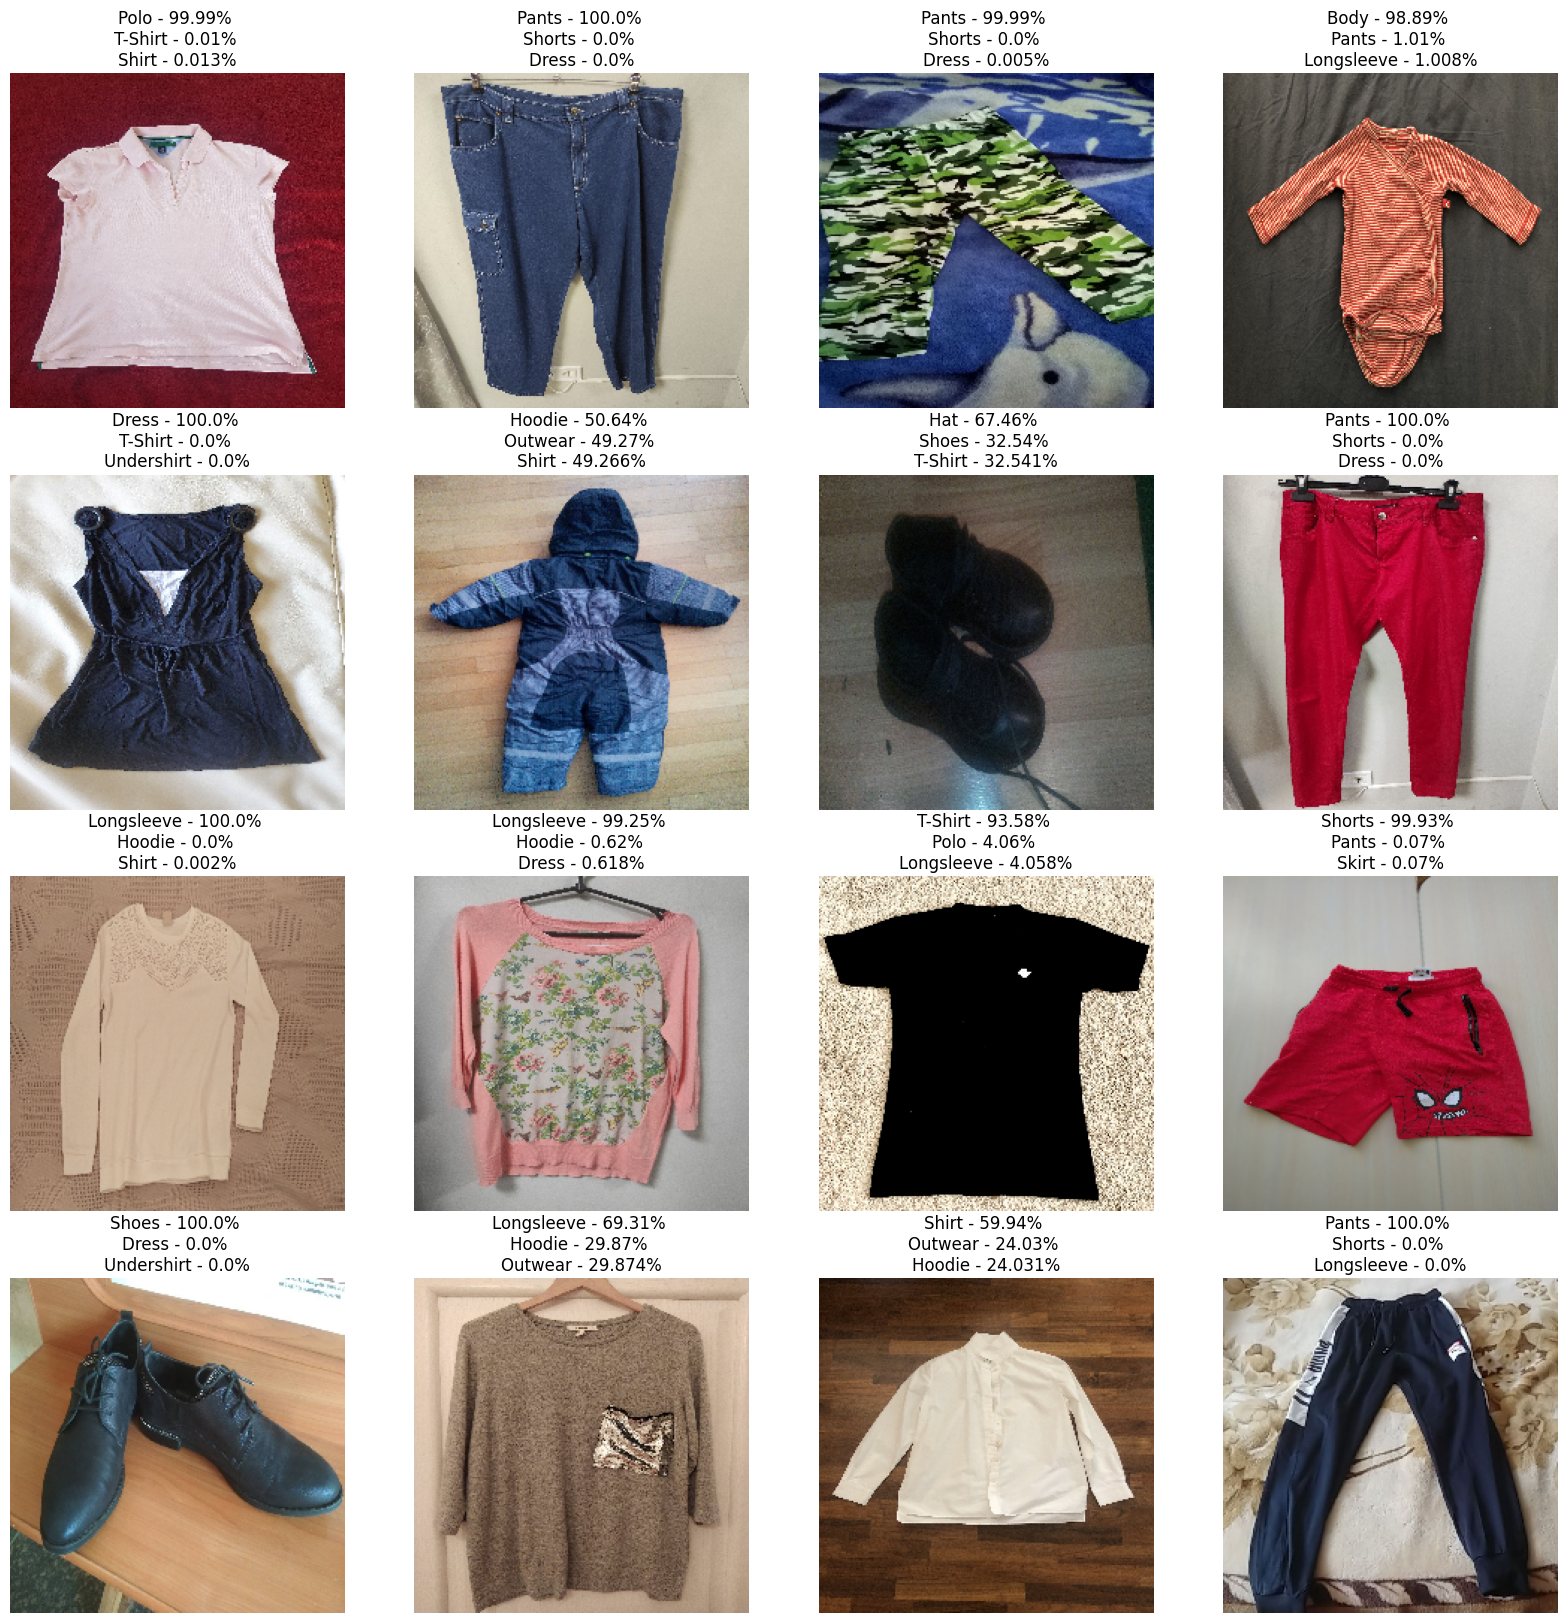

In [40]:
plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    predict_random_image()

In [41]:
model.save('mobilenetv2.h5')

16/16 [==============================] - 25s 2s/step


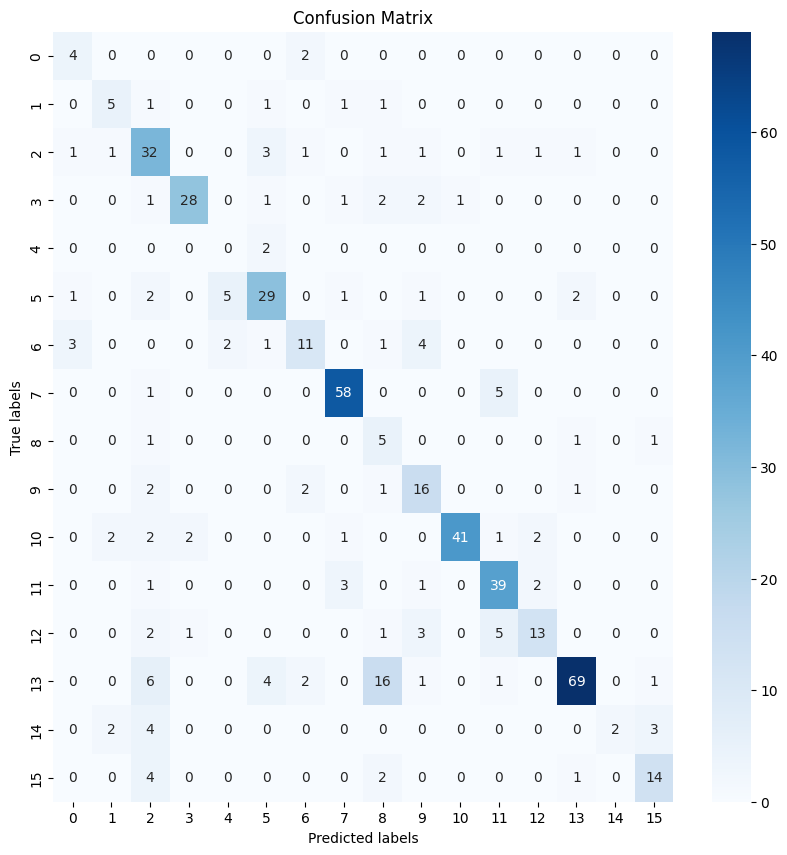

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predicting on the entire validation dataset
validation_generator.reset()  # Resetting the generator to ensure alignment of predictions and labels
y_pred = model.predict(validation_generator, steps=validation_generator.n // validation_generator.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Extracting actual labels from the generator
y_true = validation_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [50]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=classes))

              precision    recall  f1-score   support

      Blazer       0.44      0.67      0.53         6
        Body       0.50      0.56      0.53         9
       Dress       0.54      0.74      0.63        43
         Hat       0.90      0.78      0.84        36
      Hoodie       0.00      0.00      0.00         2
  Longsleeve       0.71      0.71      0.71        41
     Outwear       0.61      0.50      0.55        22
       Pants       0.89      0.91      0.90        64
        Polo       0.17      0.62      0.26         8
       Shirt       0.55      0.73      0.63        22
       Shoes       0.98      0.80      0.88        51
      Shorts       0.75      0.85      0.80        46
       Skirt       0.72      0.52      0.60        25
     T-Shirt       0.92      0.69      0.79       100
         Top       1.00      0.18      0.31        11
  Undershirt       0.74      0.67      0.70        21

    accuracy                           0.72       507
   macro avg       0.65   

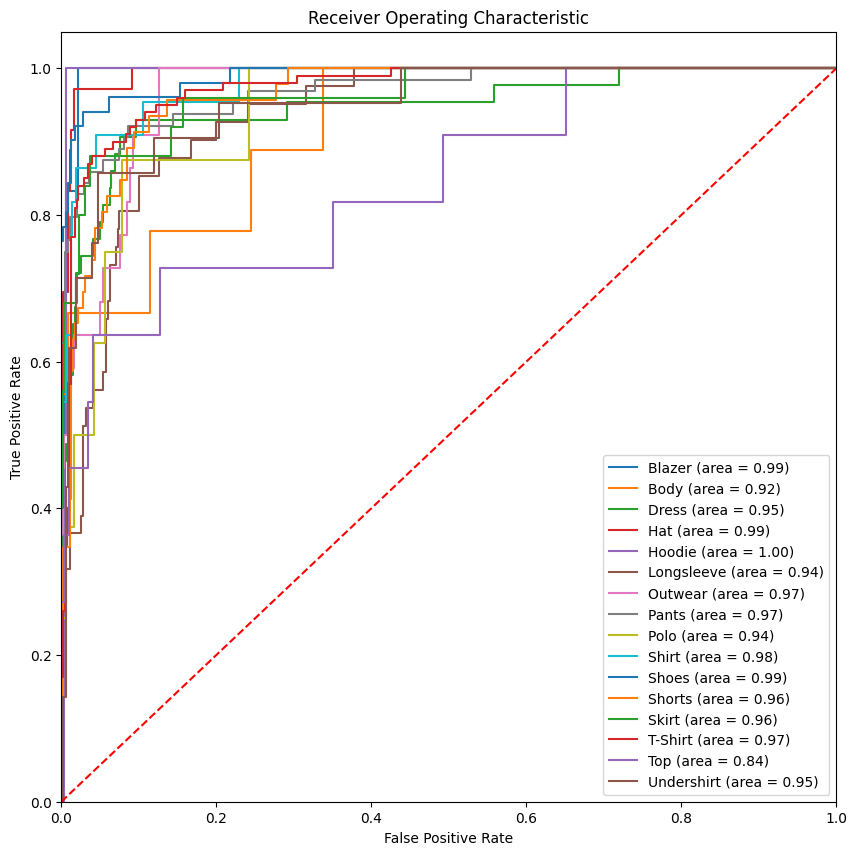

In [72]:
from sklearn.metrics import roc_curve, auc
y_true = np.array(y_true)
y_pred = np.array(y_pred)


from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10, 10))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{classes[i]} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
